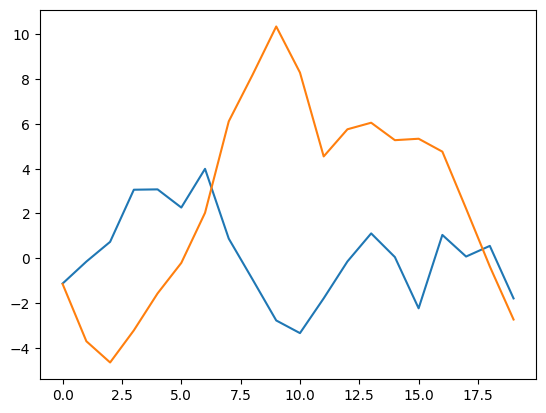

In [35]:
import torch
import matplotlib.pyplot as plt


# Assuming 'vectors' is the input tensor of shape (m, n)
def interpolate_vectors(vectors, num_vectors):
    # Perform linear interpolation to generate the required number of vectors
    interpolated_vectors = torch.nn.functional.interpolate(
        vectors.T.unsqueeze(0), size=num_vectors, mode="linear", align_corners=True
    ).squeeze(0).T
    return interpolated_vectors


# Example usage
torch.random.manual_seed(0)
# zeilen sind features, spalten sind zeit
input_vectors = torch.cumsum(torch.randn(100, 2), dim=0)
interpolated_result = interpolate_vectors(input_vectors, 20)
# print(input_vectors)
# plt.plot(input_vectors)
plt.plot(interpolated_result)
plt.show()
# num_desired_vectors = 30  # Desired number of vectors after interpolation
# interpolated_result = interpolate_vectors(input_vectors, num_desired_vectors)
# plt.plot(input_vectors.squeeze())
# plt.plot(interpolated_result.squeeze())
# plt.show()

In [1]:
from utils import MeldDataset, SequenceClassificationCollator, MmLlamaProcessor
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoConfig, AutoProcessor, AutoModel

LANGUAGE_MODEL = "/home/fock/code/MultiModalInstructERC/models/language/LLaMA2"
LORA_ADAPTER = "/home/fock/code/MultiModalInstructERC/models/language/adapter/InstructERC_unbalanced"
ACOUSTIC_MODEL = "/home/fock/code/MultiModalInstructERC/models/acoustic/wav2vec2/wav2vec2-large-robust-12-ft-emotion-msp-dim"
OUTPUT_PATH = "/home/fock/code/MultiModalInstructERC/experiments/multimodal/mlp/concat/"
DS_TRAIN_PATH = "/home/fock/code/MultiModalInstructERC/datasets/meld/train_sent_emo.csv"
DS_DEV_PATH = "/home/fock/code/MultiModalInstructERC/datasets/meld/dev_sent_emo.csv"
DS_TEST_PATH = "/home/fock/code/MultiModalInstructERC/datasets/meld/test_sent_emo.csv"


tokenizer = AutoTokenizer.from_pretrained(LANGUAGE_MODEL)
ac_config = AutoConfig.from_pretrained(ACOUSTIC_MODEL)
ac_processor = AutoProcessor.from_pretrained(ACOUSTIC_MODEL)

# setup of tokenizer
tokenizer.add_special_tokens({"additional_special_tokens": ["<audio>"]})
tokenizer.pad_token_id = tokenizer.unk_token_id
tokenizer.padding_side = "left"
processor = MmLlamaProcessor(ac_processor, tokenizer)

train_dataset = MeldDataset(DS_TRAIN_PATH, mode="train", task="normal", window=5)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=SequenceClassificationCollator(processor, mode="train"),
)

wave2vec2 = AutoModel.from_pretrained(ac_config._name_or_path)

# processed_sizes = [wave2vec2(**batch["acoustic"]).last_hidden_state.size()[1] for batch in train_dataloader]
# processed_sizes.sort()
# processed_sizes

for batch in train_dataloader:
    # print(batch["acoustic"]["input_values"].size())
    print(wave2vec2(**batch["acoustic"]).last_hidden_state.size()[1])
    break
    

# train_dataset[0]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at /home/fock/code/MultiModalInstructERC/models/acoustic/wav2vec2/wav2vec2-large-robust-12-ft-emotion-msp-dim and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: Failed to create input filter: "time_base=1/48000:sample_rate=48000:sample_fmt=fltp:channel_layout=0x0" (Invalid argument)
Exception raised from add_src at /__w/_temp/conda_environment_9285549986/conda-bld/torchaudio_1716984128252/work/src/libtorio/ffmpeg/filter_graph.cpp:91 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x57 (0x7f89985fc897 in /home/fock/code/MultiModalInstructERC/.conda/lib/python3.11/site-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7f89985acb25 in /home/fock/code/MultiModalInstructERC/.conda/lib/python3.11/site-packages/torch/lib/libc10.so)
frame #2: torio::io::FilterGraph::add_src(AVFilter const*, std::string const&) + 0x37f (0x7f88df36a71f in /home/fock/code/MultiModalInstructERC/.conda/lib/python3.11/site-packages/torio/lib/libtorio_ffmpeg6.so)
frame #3: torio::io::FilterGraph::add_audio_src(AVSampleFormat, AVRational, int, unsigned long) + 0x31 (0x7f88df36a821 in /home/fock/code/MultiModalInstructERC/.conda/lib/python3.11/site-packages/torio/lib/libtorio_ffmpeg6.so)
frame #4: <unknown function> + 0x32687 (0x7f88df37d687 in /home/fock/code/MultiModalInstructERC/.conda/lib/python3.11/site-packages/torio/lib/libtorio_ffmpeg6.so)
frame #5: torio::io::get_audio_process(AVRational, AVCodecContext*, std::string const&, int, int) + 0xfe (0x7f88df3887ee in /home/fock/code/MultiModalInstructERC/.conda/lib/python3.11/site-packages/torio/lib/libtorio_ffmpeg6.so)
frame #6: torio::io::StreamProcessor::add_stream(int, int, AVRational, std::string const&, c10::Device const&) + 0x59 (0x7f88df38c299 in /home/fock/code/MultiModalInstructERC/.conda/lib/python3.11/site-packages/torio/lib/libtorio_ffmpeg6.so)
frame #7: torio::io::StreamingMediaDecoder::add_stream(int, AVMediaType, int, int, std::string const&, std::optional<std::string> const&, std::optional<std::map<std::string, std::string, std::less<std::string>, std::allocator<std::pair<std::string const, std::string> > > > const&, c10::Device const&) + 0xdb (0x7f88df38f0cb in /home/fock/code/MultiModalInstructERC/.conda/lib/python3.11/site-packages/torio/lib/libtorio_ffmpeg6.so)
frame #8: torio::io::StreamingMediaDecoder::add_audio_stream(long, long, long, std::optional<std::string> const&, std::optional<std::string> const&, std::optional<std::map<std::string, std::string, std::less<std::string>, std::allocator<std::pair<std::string const, std::string> > > > const&) + 0x67 (0x7f88df38f3e7 in /home/fock/code/MultiModalInstructERC/.conda/lib/python3.11/site-packages/torio/lib/libtorio_ffmpeg6.so)
frame #9: <unknown function> + 0x3b30a (0x7f88d567f30a in /home/fock/code/MultiModalInstructERC/.conda/lib/python3.11/site-packages/torio/lib/_torio_ffmpeg6.so)
frame #10: <unknown function> + 0x32bf7 (0x7f88d5676bf7 in /home/fock/code/MultiModalInstructERC/.conda/lib/python3.11/site-packages/torio/lib/_torio_ffmpeg6.so)
frame #11: <unknown function> + 0x201b06 (0x563e883c4b06 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #12: _PyObject_MakeTpCall + 0x253 (0x563e883a38b3 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #13: _PyEval_EvalFrameDefault + 0x716 (0x563e883b13b6 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #14: <unknown function> + 0x25a1f8 (0x563e8841d1f8 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #15: _PyEval_EvalFrameDefault + 0x108a (0x563e883b1d2a in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #16: <unknown function> + 0x25a8f7 (0x563e8841d8f7 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #17: <unknown function> + 0x28859c (0x563e8844b59c in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #18: _PyEval_EvalFrameDefault + 0x5a2 (0x563e883b1242 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #19: <unknown function> + 0x2a5a8d (0x563e88468a8d in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #20: PyEval_EvalCode + 0x9f (0x563e8846811f in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #21: <unknown function> + 0x2bc6ee (0x563e8847f6ee in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #22: _PyEval_EvalFrameDefault + 0x38c0 (0x563e883b4560 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #23: <unknown function> + 0x2b9c39 (0x563e8847cc39 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #24: _PyEval_EvalFrameDefault + 0x3387 (0x563e883b4027 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #25: <unknown function> + 0x2b9c39 (0x563e8847cc39 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #26: _PyEval_EvalFrameDefault + 0x3387 (0x563e883b4027 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #27: <unknown function> + 0x2b9c39 (0x563e8847cc39 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #28: <unknown function> + 0x2ba5b7 (0x563e8847d5b7 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #29: <unknown function> + 0x219d69 (0x563e883dcd69 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #30: PyObject_Vectorcall + 0x2c (0x563e883bdeac in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #31: _PyEval_EvalFrameDefault + 0x716 (0x563e883b13b6 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #32: <unknown function> + 0x2308d4 (0x563e883f38d4 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #33: <unknown function> + 0x2300be (0x563e883f30be in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #34: PyObject_Call + 0x130 (0x563e883de6b0 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #35: _PyEval_EvalFrameDefault + 0x4a44 (0x563e883b56e4 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #36: <unknown function> + 0x2b9c39 (0x563e8847cc39 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #37: _PyEval_EvalFrameDefault + 0x3387 (0x563e883b4027 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #38: <unknown function> + 0x2b9c39 (0x563e8847cc39 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #39: _PyEval_EvalFrameDefault + 0x3387 (0x563e883b4027 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #40: <unknown function> + 0x2b9c39 (0x563e8847cc39 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #41: _PyEval_EvalFrameDefault + 0x3387 (0x563e883b4027 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #42: <unknown function> + 0x2b9c39 (0x563e8847cc39 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #43: _PyEval_EvalFrameDefault + 0x3387 (0x563e883b4027 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #44: <unknown function> + 0x2b9c39 (0x563e8847cc39 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #45: _PyEval_EvalFrameDefault + 0x3387 (0x563e883b4027 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #46: <unknown function> + 0x2b9c39 (0x563e8847cc39 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #47: <unknown function> + 0x78b6 (0x7f89bbb5b8b6 in /home/fock/code/MultiModalInstructERC/.conda/lib/python3.11/lib-dynload/_asyncio.cpython-311-x86_64-linux-gnu.so)
frame #48: <unknown function> + 0x2003fa (0x563e883c33fa in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #49: <unknown function> + 0x199fb5 (0x563e8835cfb5 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #50: <unknown function> + 0x19c065 (0x563e8835f065 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #51: <unknown function> + 0x1fafbf (0x563e883bdfbf in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #52: _PyEval_EvalFrameDefault + 0x8c34 (0x563e883b98d4 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #53: <unknown function> + 0x2a5a8d (0x563e88468a8d in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #54: PyEval_EvalCode + 0x9f (0x563e8846811f in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #55: <unknown function> + 0x2bc6ee (0x563e8847f6ee in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #56: <unknown function> + 0x1fafbf (0x563e883bdfbf in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #57: PyObject_Vectorcall + 0x2c (0x563e883bdeac in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #58: _PyEval_EvalFrameDefault + 0x716 (0x563e883b13b6 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #59: _PyFunction_Vectorcall + 0x181 (0x563e883d4981 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #60: <unknown function> + 0x2cf158 (0x563e88492158 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #61: Py_RunMain + 0x139 (0x563e88491ad9 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #62: Py_BytesMain + 0x37 (0x563e88458027 in /home/fock/code/MultiModalInstructERC/.conda/bin/python)
frame #63: __libc_start_main + 0xf3 (0x7f89bc4d2083 in /lib/x86_64-linux-gnu/libc.so.6)


In [1]:

import torchaudio
from glob import glob
from tqdm.auto import tqdm

paths = glob("/home/fock/code/MultiModalInstructERC/datasets/meld/audio/train/*.mp4")

i = 0
j = 0
iterator = tqdm(paths)
for path in iterator:
    try:
        torchaudio.load(path)
        j += 1
        iterator.set_description(f"Errors: {i}, Success: {j}")
    except RuntimeError as e:
        i += 1
        iterator.set_description(f"Errors: {i}, Success: {j}")

print(i)

# print(torchaudio.info("/home/fock/code/MultiModalInstructERC/datasets/meld/audio/train/dia33_utt8.mp4"))
# print(torchaudio.info("/home/fock/code/MultiModalInstructERC/datasets/meld/audio/train/dia1038_utt15.mp4"))
# print(torchaudio.info("/home/fock/code/MultiModalInstructERC/datasets/meld/audio/train/dia0_utt0.mp4"))
# print(torchaudio.info("/home/fock/code/MultiModalInstructERC/datasets/meld/audio/train/dia4_utt11.mp4"))

# torchaudio.list_audio_backends()


  0%|          | 0/9989 [00:00<?, ?it/s]

3356
